In [22]:

import pandas
import os
from metric_utils import *
import torch
import ast
import numpy as np
from swarm_visualizer.boxplot import  plot_paired_boxplot
from swarm_visualizer.utility.general_utils import save_fig, set_plot_properties
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
from seaborn import lineplot,scatterplot
warnings.filterwarnings('ignore')
from prettytable import PrettyTable

# Training and Validation Distribution Plots


condition
Clear, Dawn/Dusk     0.060402
Clear, Day           0.626483
Clear, Night         0.018527
Cloudy, Dawn/Dusk    0.007244
Cloudy, Day          0.056666
Cloudy, Night        0.006436
Rainy, Dawn/Dusk     0.018073
Rainy, Day           0.172674
Rainy, Night         0.033495
dtype: float64
condition
Clear, Dawn/Dusk     0.036788
Clear, Day           0.725561
Clear, Night         0.019862
Cloudy, Dawn/Dusk    0.008117
Cloudy, Day          0.022280
Cloudy, Night        0.008290
Rainy, Dawn/Dusk     0.055613
Rainy, Day           0.071848
Rainy, Night         0.051641
dtype: float64


Text(0, 0.5, 'Number of Samples')

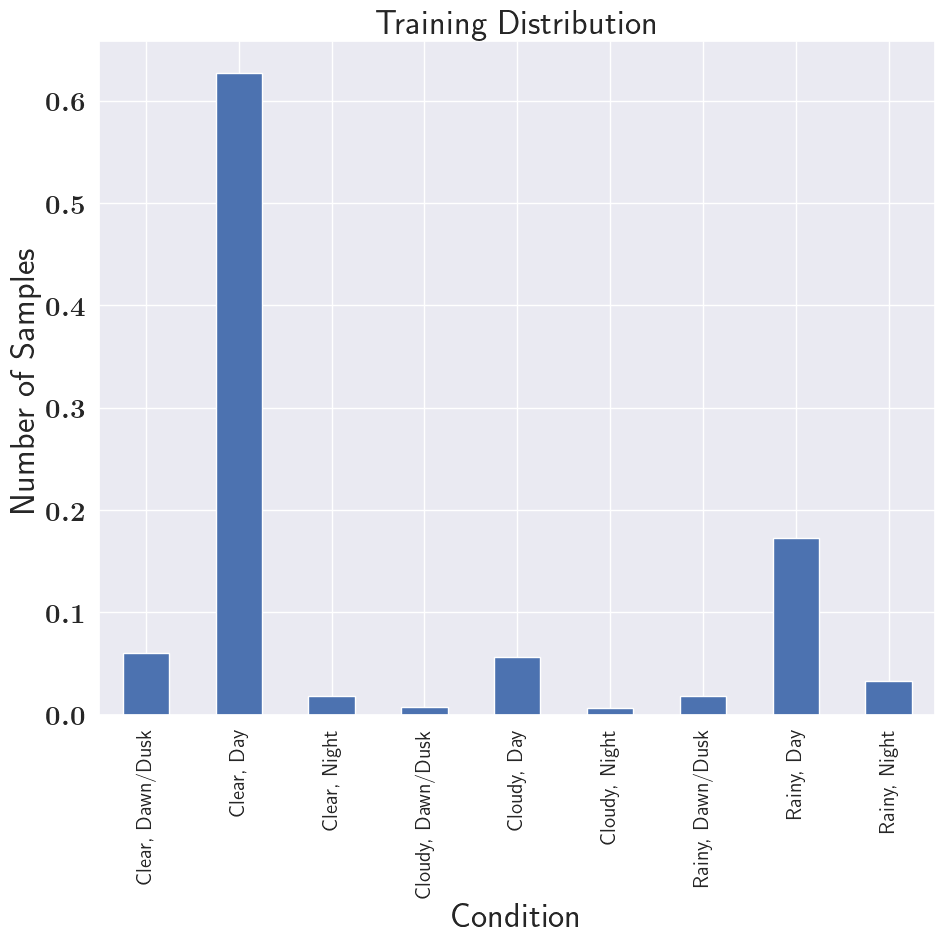

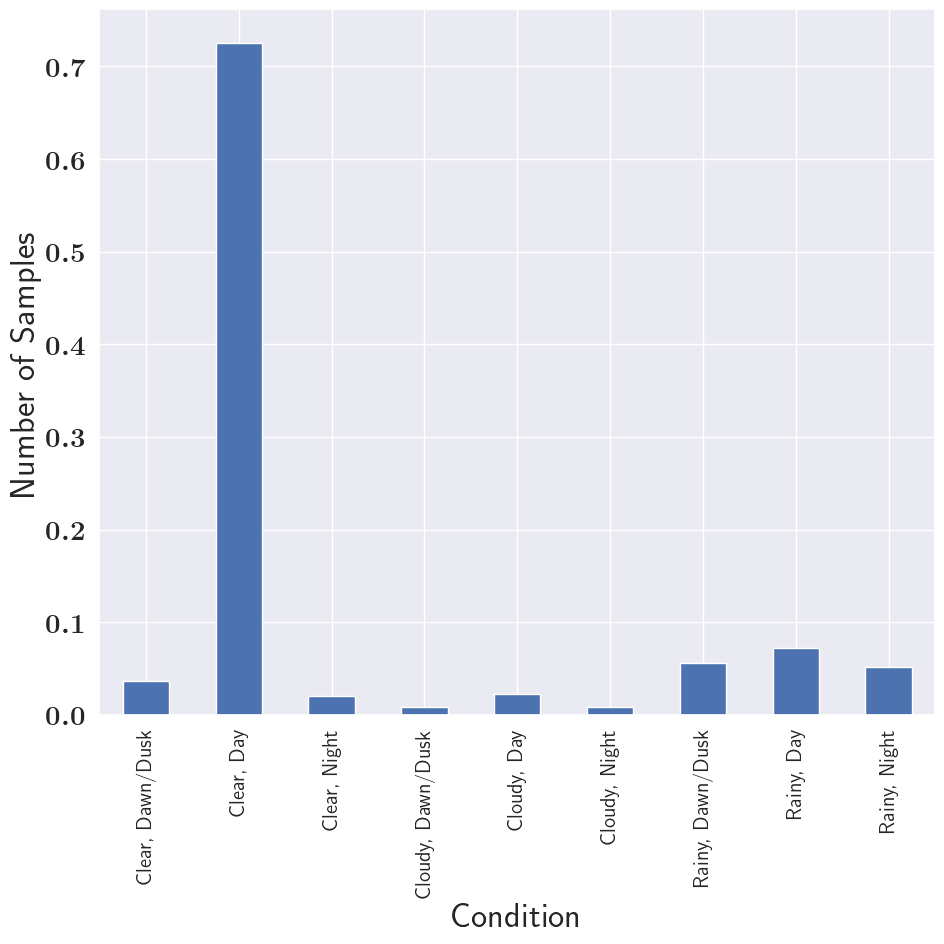

In [23]:
# Training Distribution Plots

TRAIN_FILENAME = '../../waymo_open_data/waymo_env_conditions_train.csv'
TEST_FILENAME = '../../waymo_open_data/waymo_env_conditions_val.csv'

train_df = pandas.read_csv(TRAIN_FILENAME)
plt.figure(figsize=(10, 10))
df = train_df.groupby('condition').size()/train_df.shape[0]
print(df)
df.plot(kind='bar')

plt.xlabel('Condition')
plt.ylabel('Number of Samples')
plt.title('Training Distribution')
plt.figure(figsize=(10, 10))
val_df = pandas.read_csv(TEST_FILENAME)
df = val_df.groupby('condition').size()/val_df.shape[0]
print(df)
df.plot(kind='bar')
plt.xlabel('Condition')
plt.ylabel('Number of Samples')


In [24]:
FOLDER = '../tests/'
files = os.listdir(FOLDER)
WAYMO_PALLETE = {
            'undefined' : [0, 0, 0],#1
            'ego_vehicle': [102, 102, 102],#2
            'car': [0, 0, 142], #3
            'truck': [0, 0, 70], #4
            'bus': [0, 60, 100],#5
            'other_large_vehicle': [61, 133, 198],#
            'bicycle': [119, 11, 32],#
            'motorcycle': [0, 0, 230],#
            'trailer': [111, 168, 220],#
            'pedestrian': [220, 20, 60],#10
            'cyclist': [255, 0, 0],#
            'motorcyclist': [180, 0, 0],#
            'bird': [127, 96, 0],#
            'ground_animal': [91, 15, 0],#
            'construction_cone_pole': [230, 145, 56],#15
            'pole': [153, 153, 153],#
            'pedestrian_object': [234, 153, 153],#
            'sign': [246, 178, 107],#
            'traffic_light': [250, 170, 30],#
            'building': [70, 70, 70],#20
            'road': [128, 64, 128],#
            'lane_marker': [234, 209, 220],#
            'road_marker': [217, 210, 233],#
            'sidewalk': [244, 35, 232],#
            'vegetation': [107, 142, 35],#25
            'sky': [70, 130, 180],#
            'ground': [102, 102, 102],#
            'dynamic': [102, 102, 102],#
            'static': [102, 102, 102]#
        }
WAYMO_CLASSES = np.array(list(WAYMO_PALLETE.keys()))
COMPUTE_CLASSES = np.arange(len(WAYMO_CLASSES))[2:-2]
print(WAYMO_CLASSES[COMPUTE_CLASSES])


['car' 'truck' 'bus' 'other_large_vehicle' 'bicycle' 'motorcycle'
 'trailer' 'pedestrian' 'cyclist' 'motorcyclist' 'bird' 'ground_animal'
 'construction_cone_pole' 'pole' 'pedestrian_object' 'sign'
 'traffic_light' 'building' 'road' 'lane_marker' 'road_marker' 'sidewalk'
 'vegetation' 'sky' 'ground']


# Compile Data


segformer_mit-b3_8xb2-160k_waymo-512x512
mask2former_r50_8xb2-90k_mixedwaymo-512x512
mask2former_r50_8xb2-90k_waymo-512x512


mask2former_swin-t_8xb2-160k_mixedwaymo-512x512
mask2former_swin-t_8xb2-160k_waymo-512x512
segformer_mit-b3_8xb2-160k_mixedwaymo-512x512


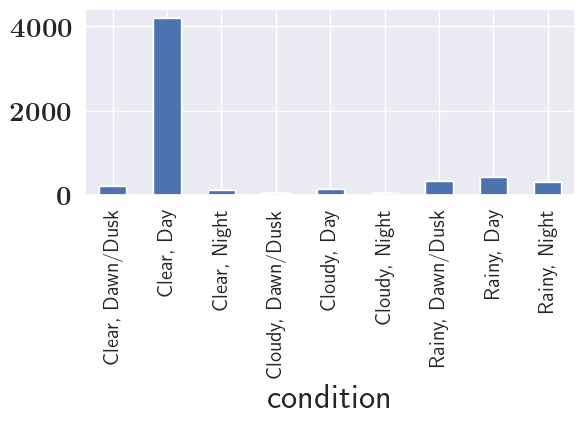

In [25]:
MODEL_DATA= dict()
for file in files:
    if file.endswith('.csv'):
        model = file.split('.')[0]
        df = pandas.read_csv(FOLDER + file)
        # Convert each relevant column to a Torch tensor
        MODEL_DATA[model] = df
        # print(len(df))
        # print(df.groupby('condition').size())
        # barplot
        print(model)
        df.groupby('condition').size().plot(kind='bar')
    
def string_to_tensor(tensor_string):
    # Convert string representation of a tensor to an actual tensor
    # Use ast.literal_eval to safely evaluate the string
    #print(tensor_string.strip("[]").split())
    array_list = [float(item) for item in tensor_string.strip("[]").split()]

    # Convert the list to a NumPy array
    np_array = np.array(array_list)

    # Convert the NumPy array to a PyTorch tensor
    tensor = torch.tensor(np_array)
    return tensor

def stack_sum_tensors(series):
    return torch.stack(series, dim=0).sum(dim=0).detach().cpu().numpy()

def mean_metrics(series, class_idx):
    #ignore nans when computing the mean
    
    series[np.isinf(series)] = np.nan
    #print(series[class_idx])
    return np.nanmean(series[class_idx]).item()

def std_metrics(series, class_idx):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    return np.nanstd(series[class_idx]).item()

def accumulate(series):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    #print(series)
    #Only return the series for class_idx and non nan values
    return series.tolist()

def per_class_metrics(df_dict):
    
    # convert data frame to dictionary where keys are the metrics and the values are a list
    # of numbers corresponding to the performance of each class
    
    #df_dict = df.to_dict(orient='list')
    # For each class compute log the mean metrics
    ret_metrics_class = OrderedDict({
        ret_metric: np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in df_dict.items()
    })
    
    class_table_data = PrettyTable()


    ret_metrics_class.update({'Class': WAYMO_CLASSES})
    ret_metrics_class.move_to_end('Class', last=False)

    for key, val in ret_metrics_class.items():
        class_table_data.add_column(key, val)

    print('per class results:\n')
    print('\n' + class_table_data.get_string())

In [26]:
MODEL_DATA[list(MODEL_DATA.keys())[0]].columns

Index(['context_name', 'context_frame', 'camera_id', 'condition',
       'mIoU_intersect', 'mIoU_union', 'mIoU_pred_label', 'mIoU_label'],
      dtype='object')

In [27]:
MODEL_DATA

{'segformer_mit-b3_8xb2-160k_waymo-512x512':                                context_name     context_frame  camera_id  \
 0     1024360143612057520_3580_000_3600_000  1553735853462203          0   
 1     1024360143612057520_3580_000_3600_000  1553735853462203          1   
 2     1024360143612057520_3580_000_3600_000  1553735853462203          2   
 3     1024360143612057520_3580_000_3600_000  1553735853662172          0   
 4     1024360143612057520_3580_000_3600_000  1553735853662172          1   
 ...                                     ...               ...        ...   
 5785   933621182106051783_4160_000_4180_000  1543516689772638          1   
 5786   933621182106051783_4160_000_4180_000  1543516689772638          2   
 5787   933621182106051783_4160_000_4180_000  1543516689972646          0   
 5788   933621182106051783_4160_000_4180_000  1543516689972646          1   
 5789   933621182106051783_4160_000_4180_000  1543516689972646          2   
 
        condition             

In [28]:
warnings.filterwarnings('always')
avg_metrics_df = pandas.DataFrame(columns=['model','condition', 'accuracy', 'IoU', 'Dice', 'F1'])
avg_metrics_df['model'] = MODEL_DATA.keys()
tensor_columns = ['mIoU_intersect', 'mIoU_union', 'mIoU_pred_label', 'mIoU_label'] 
metrics_column = ['accuracy', 'IoU', 'Dice', 'F1']
avg_metrics_col = ['mAcc','mIoU', 'mDice', 'mF1']

data_plot = dict()
avg_data_plot = dict()
for model, data in MODEL_DATA.items():
    print('RESULTS FOR MODEL: ', model)
    metrics_df = pandas.DataFrame(columns=['condition', 'accuracy', 'IoU', 'Dice', 'F1'])
    # List of tensor columns

    # Convert tensor columns from string to actual tensors
    for col in tensor_columns:
        data[col] = data[col].apply(string_to_tensor)
    
    # Compute mIoU, mAcc, mDice, mF1 across all conditions
    data_avg_all = dict(
        mIoU_intersect=[],
        mIoU_union=[],
        mIoU_pred_label=[],
        mIoU_label=[]
    )
    data_avg_all['mIoU_intersect'] = torch.stack(list(data['mIoU_intersect'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_union'] = torch.stack(list(data['mIoU_union'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_pred_label'] = torch.stack(list(data['mIoU_pred_label'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_label'] = torch.stack(list(data['mIoU_label'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
        # Pretty Table for per class metrics

    
    # for key, value in data_avg_all.items():
    #     print(data_avg_all[key].shape)
    #     print(data_avg_all[key])
    
    compiled_metrics = dict()
    
    compiled_metrics['mIoU'] = IoU = compute_IOU(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_union'])
    compiled_metrics['mAcc'] = accuracy = compute_accuracy(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_label'])
    compiled_metrics['mDice'] = Dice = compute_DICE(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_union'])
    compiled_metrics['mF1'] = f1score = compute_F1(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_pred_label'], data_avg_all['mIoU_label'])
    
    per_class_metrics(compiled_metrics)
    
    print('mIoU: ', np.nanmean(IoU).item())
    print('mAcc: ', np.nanmean(accuracy).item())
    print('mDice: ', np.nanmean(Dice).item())
    print('mF1: ', np.nanmean(f1score).item())
    
    
    grouped_data = data.groupby('condition')[tensor_columns]
    grouped_data = grouped_data.agg(list)
    num_items = grouped_data.applymap(len)
    grouped_sum = grouped_data.applymap(stack_sum_tensors)
    
    grouped_sum['accuracy'] = compute_accuracy(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_label'])
    grouped_sum['IoU'] = compute_IOU(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['Dice'] = compute_DICE(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['F1'] = compute_F1(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_pred_label'], grouped_sum['mIoU_label'])
    metrics_df = grouped_sum[metrics_column]
    
    metrics_df_post = metrics_df.copy()
    metrics_df_post['accuracy']= metrics_df['accuracy'].apply(accumulate)
    metrics_df_post['IoU'] = metrics_df['IoU'].apply(accumulate)
    metrics_df_post['Dice']= metrics_df['Dice'].apply(accumulate)
    metrics_df_post['F1']= metrics_df['F1'].apply(accumulate)
    data_plot[model] = metrics_df_post
    

    
    # Compute mean and std across all conditions
    metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mIoU'] = metrics_df['IoU'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mDice'] = metrics_df['Dice'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mF1'] = metrics_df['F1'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdAcc'] = metrics_df['accuracy'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdIoU'] = metrics_df['IoU'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdDice'] = metrics_df['Dice'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdF1'] = metrics_df['F1'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    avg_metrics_df = metrics_df[avg_metrics_col]
    avg_data_plot[model] = avg_metrics_df.copy()
    #print(avg_metrics_df)




RESULTS FOR MODEL:  segformer_mit-b3_8xb2-160k_waymo-512x512


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:20: RuntimeWarning: invalid value encountered in divide
  precision = total_area_intersect / total_area_pred_label
/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_545200/1958103786.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_545200/1958103786.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

per class results:


+------------------------+-------+-------+-------+-------+
|         Class          |  mIoU |  mAcc | mDice |  mF1  |
+------------------------+-------+-------+-------+-------+
|       undefined        | 23.88 | 32.56 | 38.55 | 38.55 |
|      ego_vehicle       |  2.1  |  2.11 |  4.11 |  4.11 |
|          car           | 91.99 | 96.94 | 95.83 | 95.83 |
|         truck          | 65.17 | 69.33 | 78.92 | 78.92 |
|          bus           |  7.34 | 40.57 | 13.67 | 13.67 |
|  other_large_vehicle   |  0.16 |  0.25 |  0.32 |  0.32 |
|        bicycle         | 59.32 | 76.73 | 74.46 | 74.46 |
|       motorcycle       | 64.96 | 74.85 | 78.76 | 78.76 |
|        trailer         |  9.65 | 13.44 | 17.61 | 17.61 |
|       pedestrian       |  71.0 | 85.46 | 83.04 | 83.04 |
|        cyclist         | 32.76 | 37.41 | 49.36 | 49.36 |
|      motorcyclist      |  0.0  |  0.0  |  0.0  |  nan  |
|          bird          |  0.0  |  0.0  |  0.0  |  nan  |
|     ground_animal      |  0.0  | 

/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_545200/1958103786.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_545200/1958103786.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU'] =

per class results:


+------------------------+-------+-------+-------+-------+
|         Class          |  mIoU |  mAcc | mDice |  mF1  |
+------------------------+-------+-------+-------+-------+
|       undefined        | 19.02 | 73.45 | 31.96 | 31.96 |
|      ego_vehicle       |  6.06 |  7.16 | 11.42 | 11.42 |
|          car           | 92.58 |  96.1 | 96.15 | 96.15 |
|         truck          | 63.08 | 71.83 | 77.36 | 77.36 |
|          bus           | 11.17 | 55.07 | 20.09 | 20.09 |
|  other_large_vehicle   |  0.16 |  0.46 |  0.32 |  0.32 |
|        bicycle         | 29.79 | 37.59 |  45.9 |  45.9 |
|       motorcycle       | 46.92 | 64.88 | 63.87 | 63.87 |
|        trailer         | 26.76 | 37.69 | 42.22 | 42.22 |
|       pedestrian       | 74.41 |  86.6 | 85.32 | 85.32 |
|        cyclist         | 18.39 | 27.23 | 31.06 | 31.06 |
|      motorcyclist      |  0.0  |  0.0  |  0.0  |  nan  |
|          bird          |  0.5  |  0.53 |  1.0  |  1.0  |
|     ground_animal      |  0.24 | 

/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_545200/1958103786.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_545200/1958103786.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU'] =

per class results:


+------------------------+-------+-------+-------+-------+
|         Class          |  mIoU |  mAcc | mDice |  mF1  |
+------------------------+-------+-------+-------+-------+
|       undefined        | 19.83 | 67.39 |  33.1 |  33.1 |
|      ego_vehicle       | 14.27 | 18.75 | 24.98 | 24.98 |
|          car           | 91.14 | 94.61 | 95.36 | 95.36 |
|         truck          | 49.25 | 69.12 |  66.0 |  66.0 |
|          bus           |  8.49 | 56.39 | 15.66 | 15.66 |
|  other_large_vehicle   |  0.08 |  0.22 |  0.15 |  0.15 |
|        bicycle         | 42.35 | 53.18 |  59.5 |  59.5 |
|       motorcycle       | 52.52 | 67.33 | 68.87 | 68.87 |
|        trailer         |  41.1 | 56.56 | 58.26 | 58.26 |
|       pedestrian       | 75.08 | 87.05 | 85.77 | 85.77 |
|        cyclist         |  26.0 | 37.03 | 41.27 | 41.27 |
|      motorcyclist      |  0.0  |  0.0  |  0.0  |  nan  |
|          bird          |  3.46 |  4.09 |  6.68 |  6.68 |
|     ground_animal      |  0.66 | 

/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_545200/1958103786.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_545200/1958103786.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU'] =

per class results:


+------------------------+-------+-------+-------+-------+
|         Class          |  mIoU |  mAcc | mDice |  mF1  |
+------------------------+-------+-------+-------+-------+
|       undefined        | 24.15 |  44.7 | 38.91 | 38.91 |
|      ego_vehicle       |  7.66 | 11.77 | 14.22 | 14.22 |
|          car           | 93.17 | 96.59 | 96.47 | 96.47 |
|         truck          | 71.51 | 78.66 | 83.39 | 83.39 |
|          bus           | 13.52 | 60.93 | 23.82 | 23.82 |
|  other_large_vehicle   |  0.31 |  0.53 |  0.61 |  0.61 |
|        bicycle         | 64.12 | 75.88 | 78.14 | 78.14 |
|       motorcycle       | 68.52 | 76.26 | 81.32 | 81.32 |
|        trailer         | 23.24 | 45.91 | 37.72 | 37.72 |
|       pedestrian       | 77.31 | 88.06 |  87.2 |  87.2 |
|        cyclist         | 37.42 | 45.68 | 54.46 | 54.46 |
|      motorcyclist      |  0.0  |  0.0  |  0.0  |  nan  |
|          bird          |  0.66 |  0.8  |  1.3  |  1.3  |
|     ground_animal      |  1.85 | 

/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_545200/1958103786.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_545200/1958103786.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU'] =

per class results:


+------------------------+-------+-------+-------+-------+
|         Class          |  mIoU |  mAcc | mDice |  mF1  |
+------------------------+-------+-------+-------+-------+
|       undefined        | 26.05 | 53.73 | 41.33 | 41.33 |
|      ego_vehicle       |  2.02 |  4.52 |  3.95 |  3.95 |
|          car           | 93.33 | 96.71 | 96.55 | 96.55 |
|         truck          |  71.7 | 77.85 | 83.52 | 83.52 |
|          bus           | 10.46 | 57.64 | 18.94 | 18.94 |
|  other_large_vehicle   |  3.76 |  5.01 |  7.25 |  7.25 |
|        bicycle         | 63.84 | 80.41 | 77.93 | 77.93 |
|       motorcycle       | 68.17 | 75.47 | 81.07 | 81.07 |
|        trailer         | 26.89 | 38.07 | 42.38 | 42.38 |
|       pedestrian       | 77.86 | 88.07 | 87.55 | 87.55 |
|        cyclist         |  40.5 | 49.62 | 57.65 | 57.65 |
|      motorcyclist      |  0.0  |  0.0  |  0.0  |  nan  |
|          bird          |  0.14 |  0.16 |  0.28 |  0.28 |
|     ground_animal      |  0.77 | 

/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:20: RuntimeWarning: invalid value encountered in divide
  precision = total_area_intersect / total_area_pred_label
/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_545200/1958103786.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_545200/1958103786.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

# Plot performance of original models


In [29]:
# Formatting data plot items
original_data_plot = {}
for model, data_ in data_plot.items():
    print(model)
    if 'synth' not in model and 'mixed' not in model:
        data=data_.copy()
        data['model'] = model
        
        if 'mask2former_swin' in model:
            data['model_cat'] = 'Mask2Former Swin-T' 
        elif 'mask2former_r50' in model:
            data['model_cat'] = 'Mask2Former Resnet 50' 
        elif 'segformer' in model:
            data['model_cat'] = 'Segformer'
        # print(data.columns)
        # print(data.index)
        data.reset_index(inplace=True)
        print(data.index)
        print(data.columns)
        data['accuracy'] = data['accuracy'].apply(np.nanmean)
        data['IoU'] = data['IoU'].apply(np.nanmean)
        data['Dice'] = data['Dice'].apply(np.nanmean)
        data['F1'] = data['F1'].apply(np.nanmean)
        original_data_plot[model] = data
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data_original = pd.concat([dfs for dfs in original_data_plot.values()], ignore_index=True)

segformer_mit-b3_8xb2-160k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat'], dtype='object')
mask2former_r50_8xb2-90k_mixedwaymo-512x512
mask2former_r50_8xb2-90k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat'], dtype='object')
mask2former_swin-t_8xb2-160k_mixedwaymo-512x512
mask2former_swin-t_8xb2-160k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat'], dtype='object')
segformer_mit-b3_8xb2-160k_mixedwaymo-512x512


/tmp/ipykernel_545200/3899876757.py:13: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  lineplot(all_data_original,


Text(0.5, 0, 'Conditions')

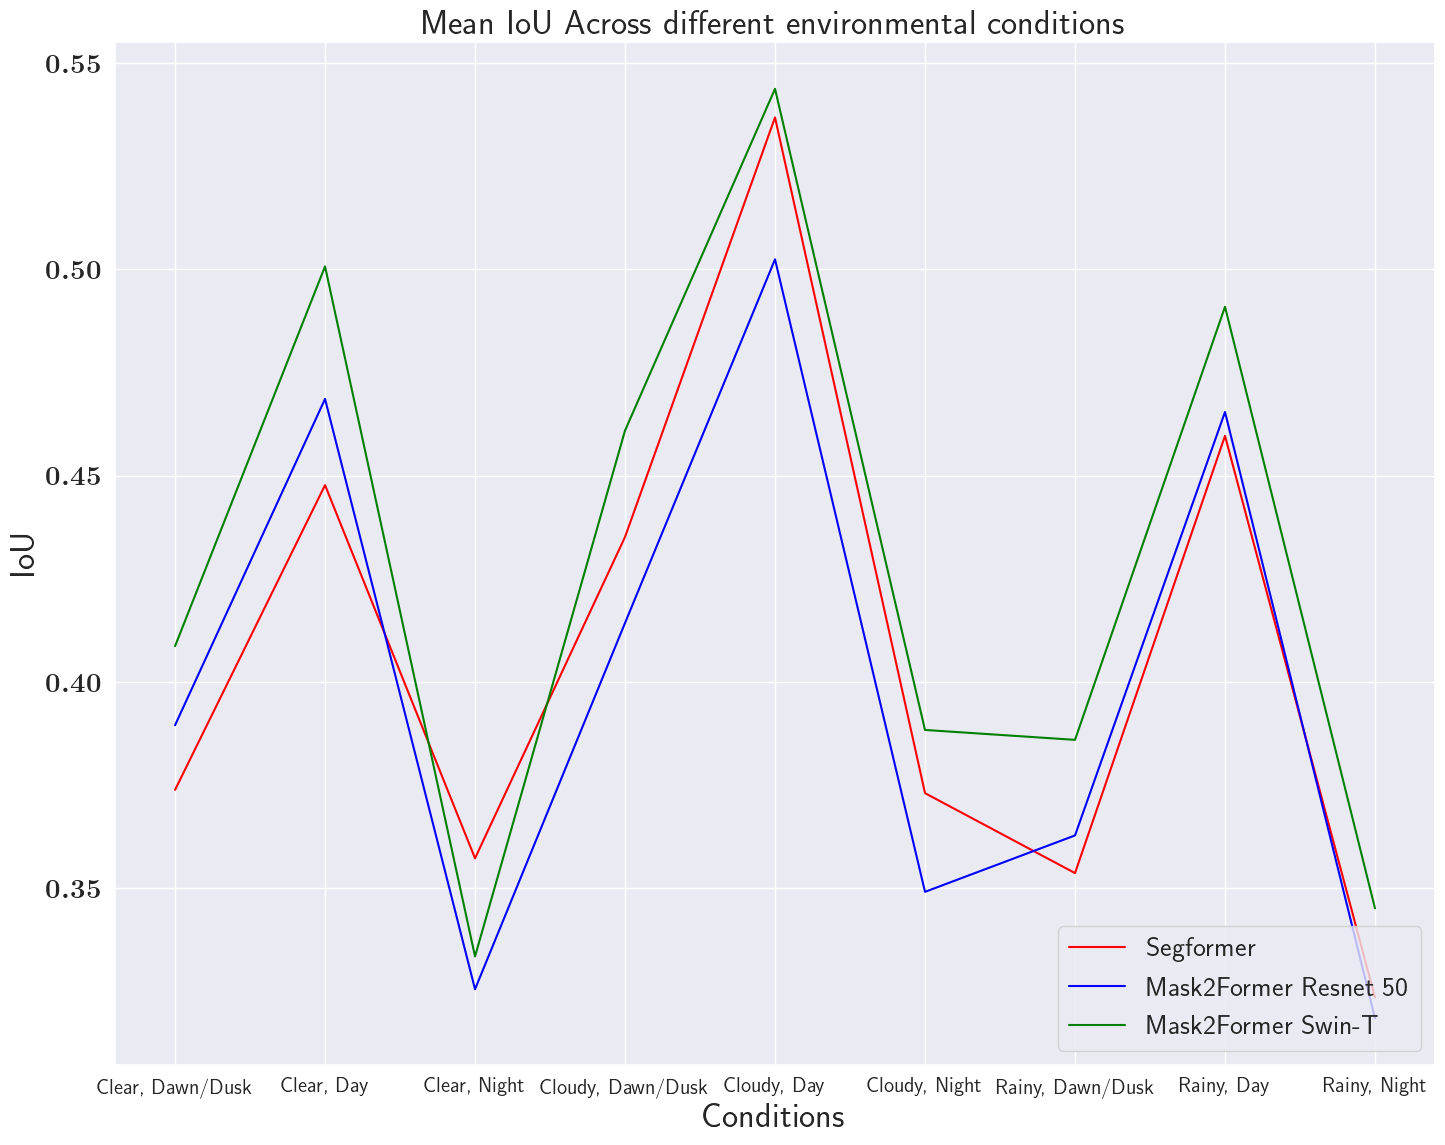

In [30]:
# Line plot of accuracy with respect to conditions
set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 15,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))

lineplot(all_data_original,
                    x='condition',
                    y='IoU', 
                    hue='model_cat', 
                    palette=pallete,
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('Mean IoU Across different environmental conditions', fontsize=25)
plt.ylabel('IoU', fontsize=25)
plt.xlabel('Conditions', fontsize=25)



# Print the per condition scores for all models

In [31]:
print(avg_data_plot.keys())
print(avg_data_plot.values())

dict_keys(['segformer_mit-b3_8xb2-160k_waymo-512x512', 'mask2former_r50_8xb2-90k_mixedwaymo-512x512', 'mask2former_r50_8xb2-90k_waymo-512x512', 'mask2former_swin-t_8xb2-160k_mixedwaymo-512x512', 'mask2former_swin-t_8xb2-160k_waymo-512x512', 'segformer_mit-b3_8xb2-160k_mixedwaymo-512x512'])
dict_values([                       mAcc      mIoU     mDice       mF1
condition                                                
Clear, Dawn/Dusk   0.473587  0.404171  0.481851  0.692661
Clear, Day         0.565707  0.488481  0.574612  0.652968
Clear, Night       0.549441  0.402844  0.512560  0.630843
Cloudy, Dawn/Dusk  0.609901  0.471675  0.544248  0.689381
Cloudy, Day        0.623950  0.552393  0.638528  0.702381
Cloudy, Night      0.505871  0.409365  0.516973  0.596508
Rainy, Dawn/Dusk   0.446915  0.378711  0.455346  0.669627
Rainy, Day         0.593833  0.503049  0.599771  0.685453
Rainy, Night       0.499474  0.370448  0.465379  0.644371,                        mAcc      mIoU     mDice       mF1

In [32]:
# Formatting data plot items
original_data_plot_avg= {}
for model, data in avg_data_plot.items():
    print(model)


    data['model'] = model
    
    if 'mask2former_swin' in model:
        data['model_cat'] = 'Mask2Former Swin-T' 
    elif 'mask2former_r50' in model:
        data['model_cat'] = 'Mask2Former Resnet 50' 
    elif 'segformer' in model:
        data['model_cat'] = 'Segformer'
    # print(data.columns)
    # print(data.index)
    data.reset_index(inplace=True)
    print(data.index)
    print(data.columns)
    original_data_plot_avg[model] = data
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data_original_avg = pd.concat([dfs for dfs in original_data_plot_avg.values()], ignore_index=True)

segformer_mit-b3_8xb2-160k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
mask2former_r50_8xb2-90k_mixedwaymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
mask2former_r50_8xb2-90k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
mask2former_swin-t_8xb2-160k_mixedwaymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
mask2former_swin-t_8xb2-160k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
segformer_mit-b3_8xb2-160k_mixedwaymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_

In [33]:
# Print the average metrics across all conditions

# Pretty Table for per class metrics
MDOELS = ['Mask2Former Swin-T', 'Mask2Former Resnet 50', 'Segformer']
metrics_column = ['mAcc','mIoU', 'mDice', 'mF1']
avg_metrics_table_data_dict = { k:PrettyTable() for k in MDOELS}
for model, data_ in avg_data_plot.items():
    metrics = data_[metrics_column]
    model_cat = data_['model_cat'].unique()[0]
    
    if 'mixed' in model:
        ret_metrics_cond = OrderedDict({
        ret_metric+'_mix': np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in metrics.items()
         })
    else:
        ret_metrics_cond = OrderedDict({
        ret_metric: np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in metrics.items()
         })
    ret_metrics_cond.update({'Condition': list(data_['condition'])})
    ret_metrics_cond.move_to_end('Condition', last=False)

    avg_metrics_table_data_dict[model_cat].title = model_cat
    for key, val in ret_metrics_cond.items():
        avg_metrics_table_data_dict[model_cat].add_column(key, val)
    
for model, table in avg_metrics_table_data_dict.items():
    print(table)
    print('\n')



+-------------------------------------------------------------------------------------------------------------------+
|                                                 Mask2Former Swin-T                                                |
+-------------------+----------+----------+-----------+---------+-------------------+-------+-------+-------+-------+
|     Condition     | mAcc_mix | mIoU_mix | mDice_mix | mF1_mix |     Condition     |  mAcc |  mIoU | mDice |  mF1  |
+-------------------+----------+----------+-----------+---------+-------------------+-------+-------+-------+-------+
|  Clear, Dawn/Dusk |  58.21   |  43.75   |   51.03   |  70.87  |  Clear, Dawn/Dusk | 57.76 | 43.36 | 50.43 | 70.05 |
|     Clear, Day    |  64.43   |  54.65   |   63.38   |  66.02  |     Clear, Day    | 64.65 | 54.92 | 63.65 |  66.3 |
|    Clear, Night   |  65.79   |  40.45   |   50.66   |  70.14  |    Clear, Night   | 63.21 |  37.9 |  47.7 | 69.71 |
| Cloudy, Dawn/Dusk |  67.57   |  49.69   |   56.25   | 

# Plot performance of all trained models


In [34]:
# Formatting data plot items
for model, data in data_plot.items():
    print(model)
    data['model'] = model
    # print(data.columns)
    # print(data.index)
    data.reset_index(inplace=True)

    if 'mask2former_swin' in model:
        data['model_cat'] = 'Mask2Former Swin-T' 
    elif 'mask2former_r50' in model:
        data['model_cat'] = 'Mask2Former Resnet 50' 
    elif 'segformer' in model:
        data['model_cat'] = 'Segformer'
    
    if 'synth' in model:
        data['dataset'] = 'Synthetic'
    elif 'mixed' in model:
        data['dataset'] = 'Mixed'
    else:
        data['dataset'] = 'Real'
    print(data.index)
    print(data.columns)
        
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data = pd.concat([dfs for dfs in data_plot.values()], ignore_index=True)
model_idxs = {'r50':[],'swin':[],'segformer':[]}

# store the indices of the models which contain the keys

for idx, model in enumerate(all_data['model']):
    if 'r50' in model:
        model_idxs['r50'].append(idx)
    elif 'swin' in model:
        model_idxs['swin'].append(idx)
    elif 'segformer' in model:
        model_idxs['segformer'].append(idx)
    else:
        print('Model not found')

segformer_mit-b3_8xb2-160k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
mask2former_r50_8xb2-90k_mixedwaymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
mask2former_r50_8xb2-90k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
mask2former_swin-t_8xb2-160k_mixedwaymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
mask2former_swin-t_8xb2-160k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
segformer_mit-b3_8xb2-160

Plots for model:  r50
     index                                        model         condition  \
0        9  mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk   
1        9  mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk   
2        9  mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk   
3        9  mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk   
4        9  mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk   
..     ...                                          ...               ...   
517     26       mask2former_r50_8xb2-90k_waymo-512x512      Rainy, Night   
518     26       mask2former_r50_8xb2-90k_waymo-512x512      Rainy, Night   
519     26       mask2former_r50_8xb2-90k_waymo-512x512      Rainy, Night   
520     26       mask2former_r50_8xb2-90k_waymo-512x512      Rainy, Night   
521     26       mask2former_r50_8xb2-90k_waymo-512x512      Rainy, Night   

     accuracy dataset  
0    0.600504   Mixed  
1    

/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(
/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(
/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(


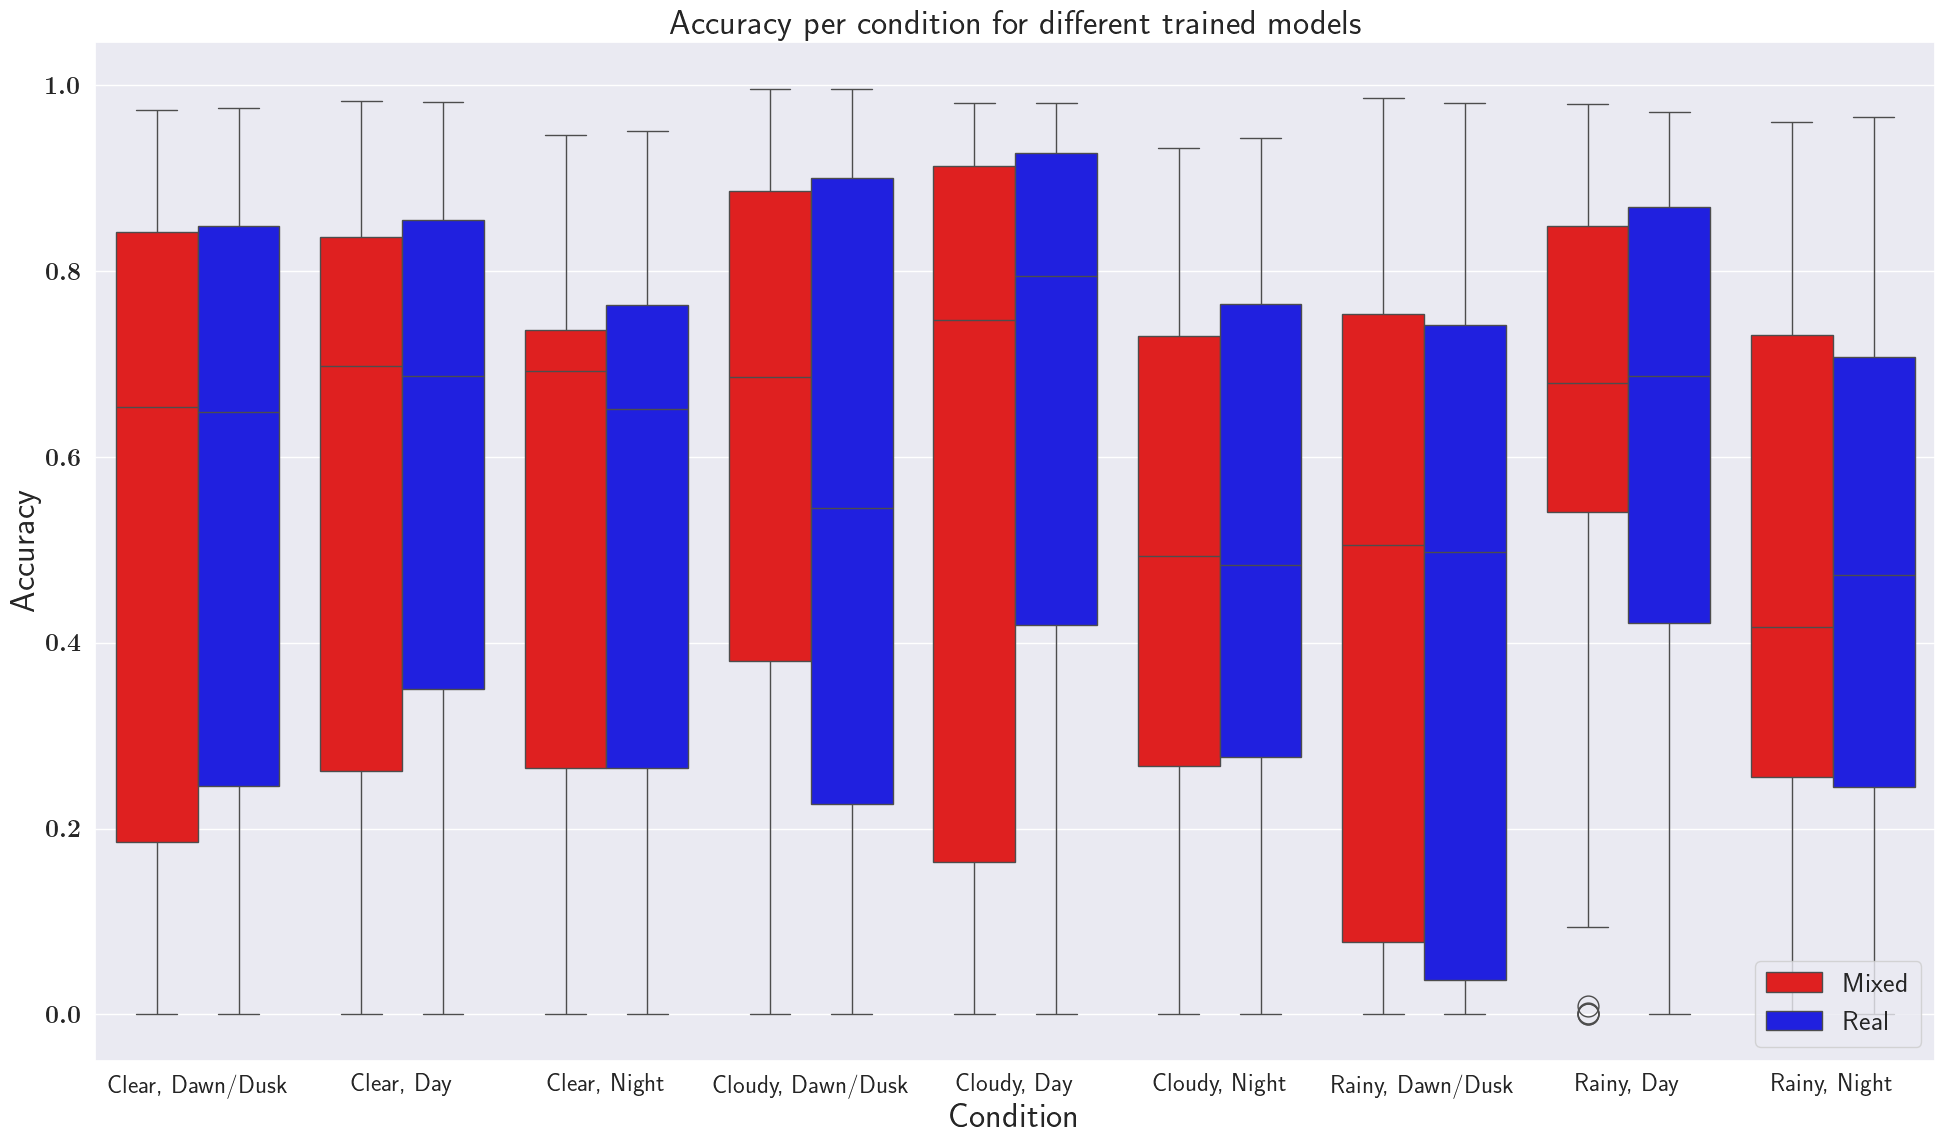

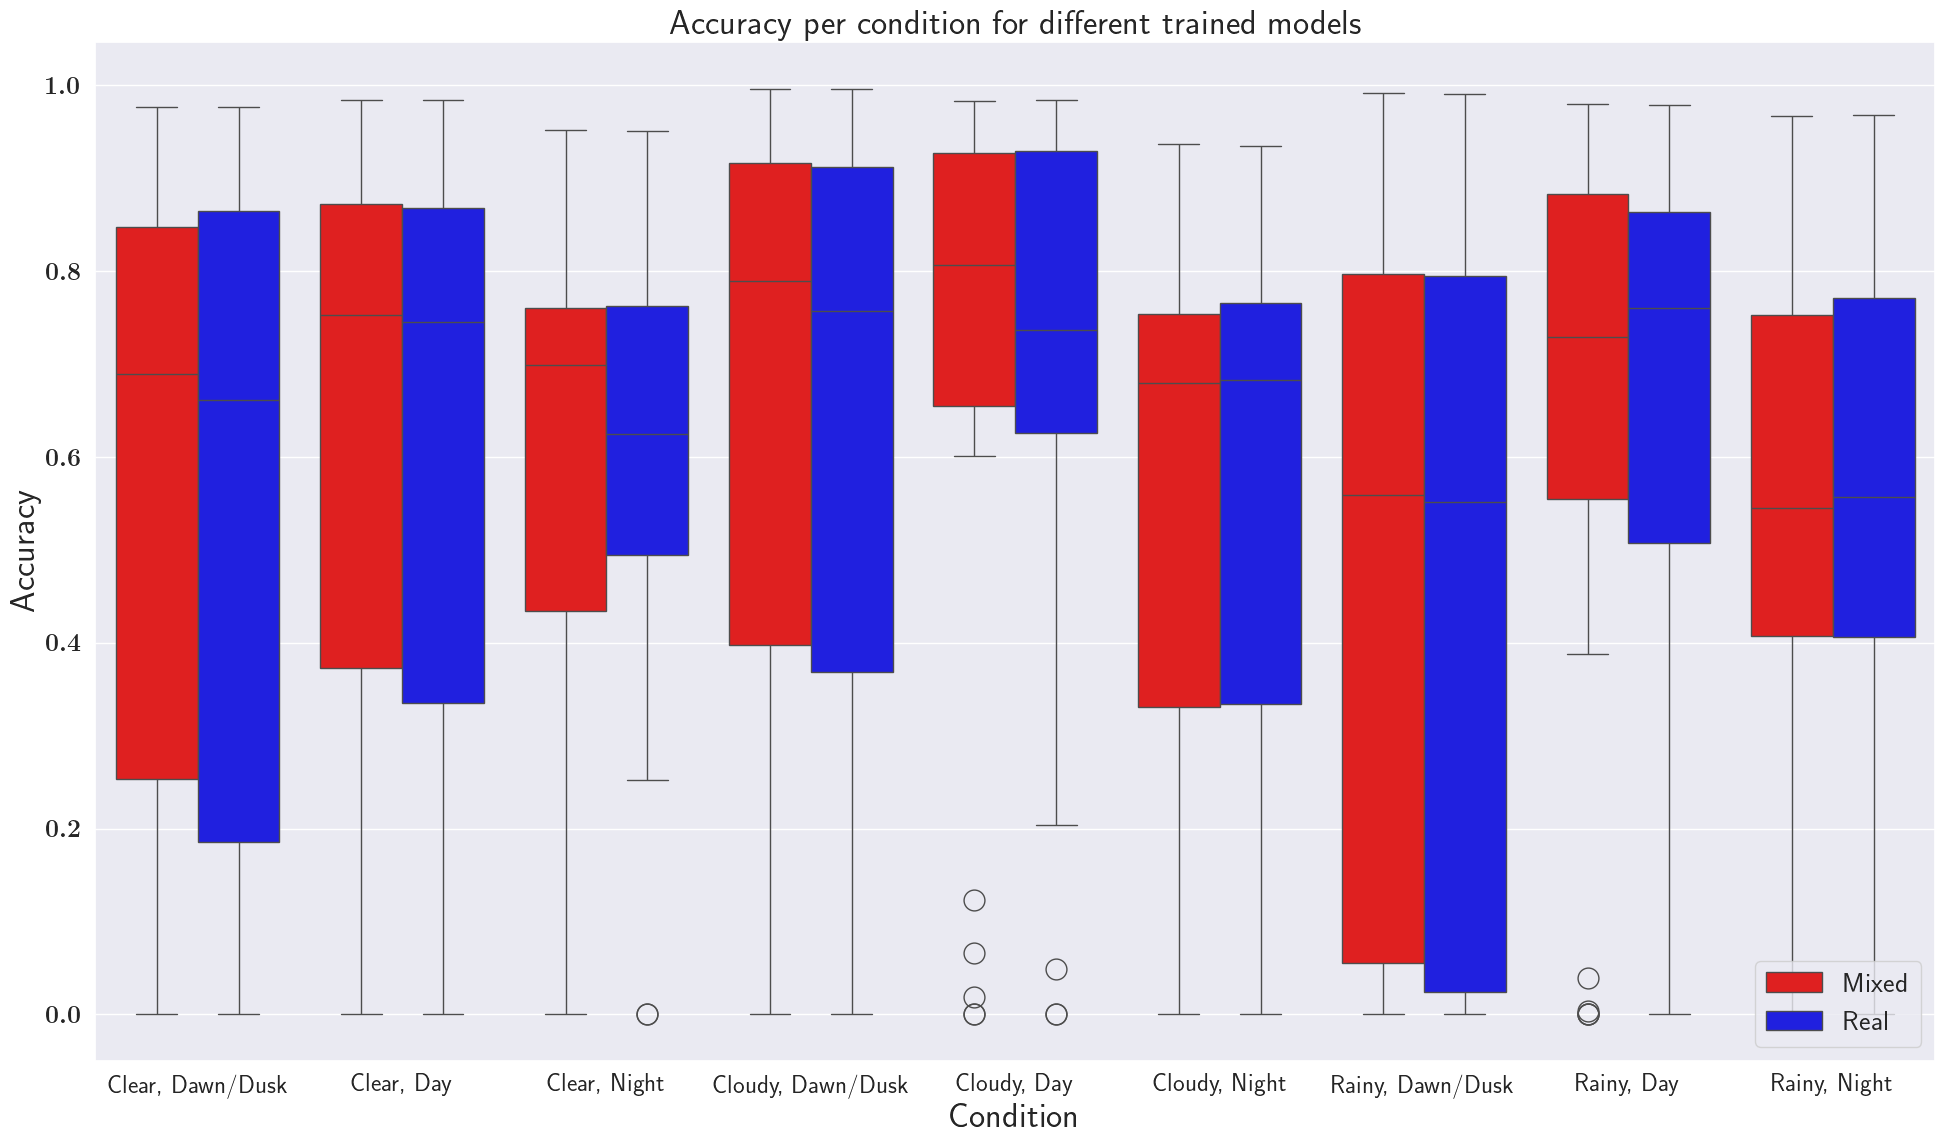

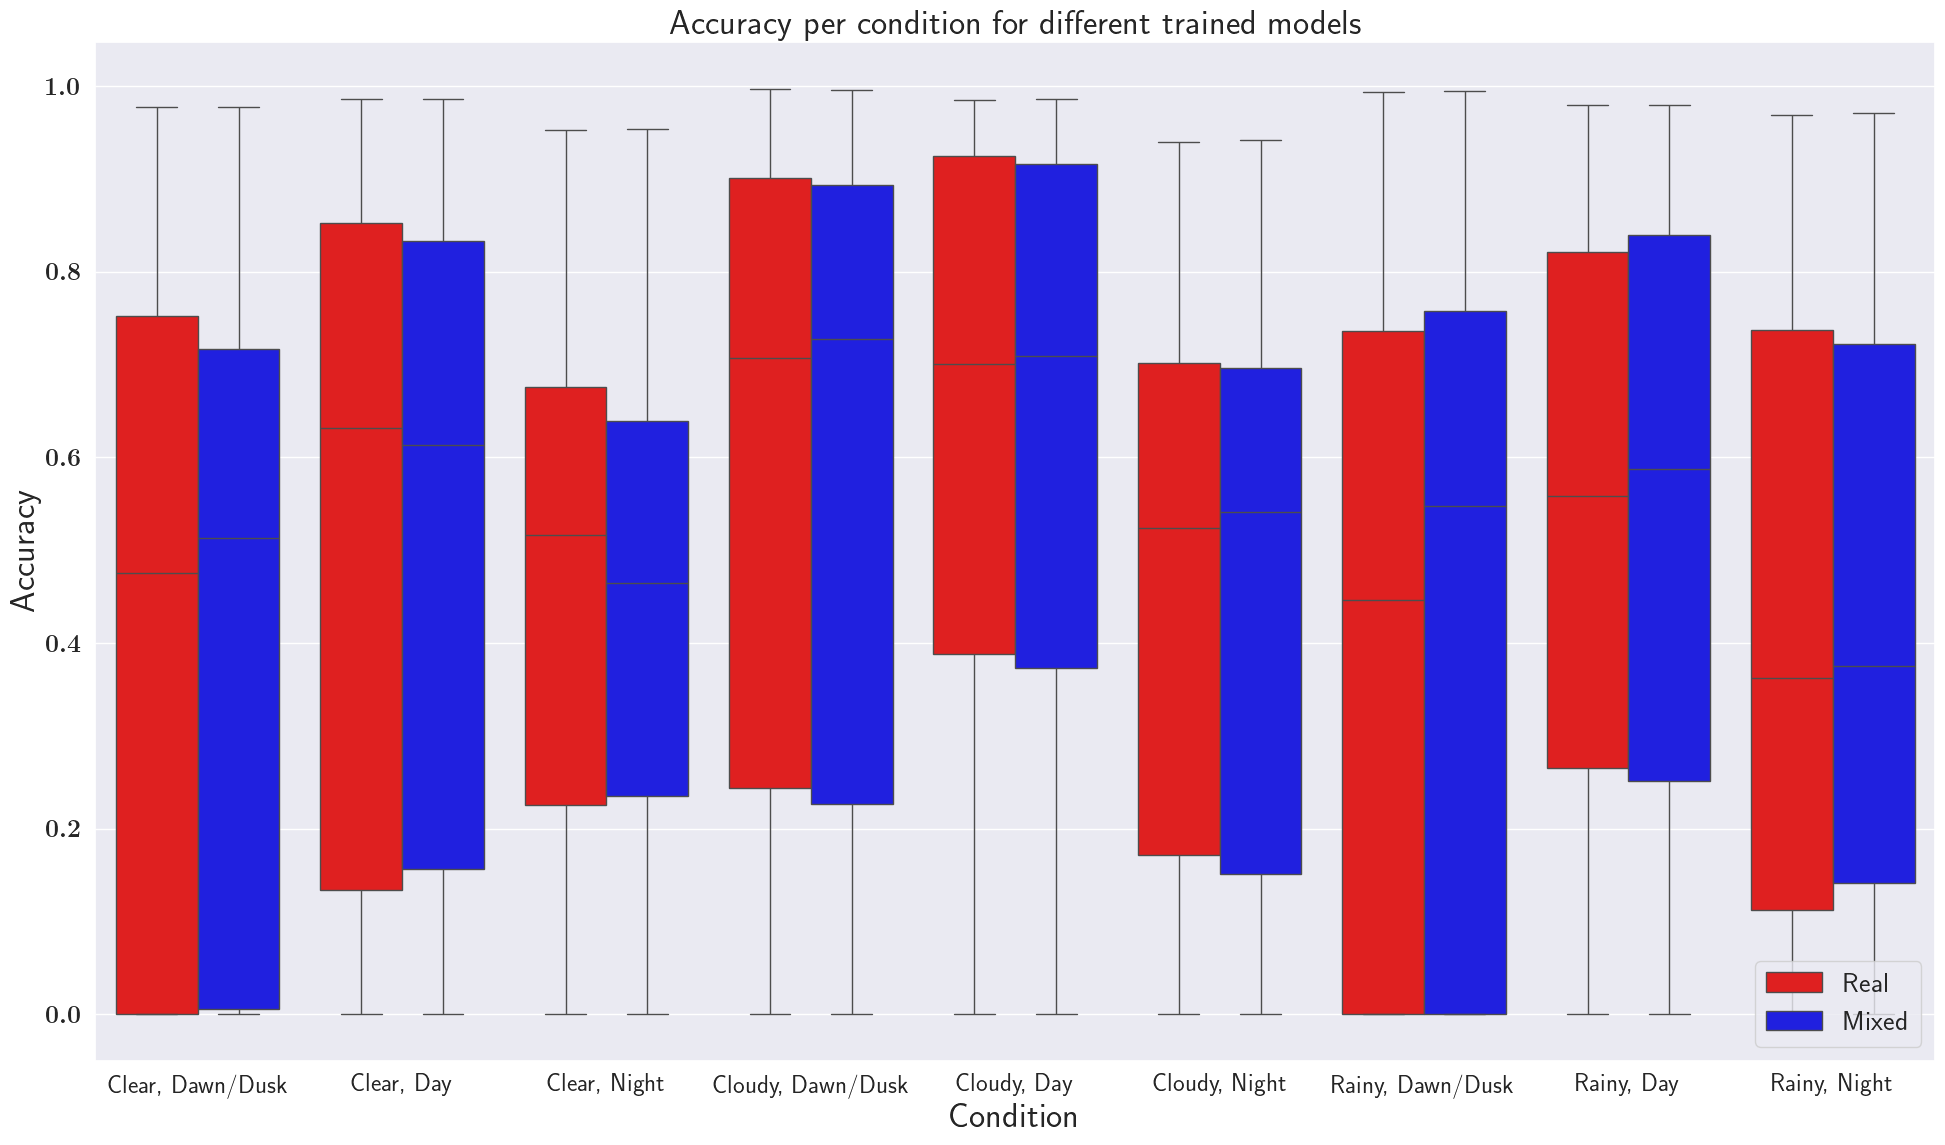

In [35]:
# Plotting the results in a box plot
# Combine the dataframes into a single dataframe in data_plot

for k,v in model_idxs.items():
    print('Plots for model: ', k)
    all_data_acc = pd.DataFrame(columns=['model', 'condition', 'accuracy'])
    all_data_acc['model'] = all_data['model']
    all_data_acc['condition'] = all_data['condition']
    all_data_acc['accuracy'] = all_data['accuracy']
    all_data_acc['dataset'] = all_data['dataset']
    all_data_acc = all_data_acc.iloc[v]
    all_data_acc = all_data_acc.explode('accuracy').reset_index()

    print(all_data_acc)
    set_plot_properties(
        font_size= 25,
        legend_font_size = 20,
        xtick_label_size = 20,
        ytick_label_size = 20,
        markersize = 15,
        usetex = True,
    )
    # Creating a box plot for accuracy of each ltl_group, differentiated by model
    fig, ax = plt.subplots(figsize=(20, 12))
    plot_paired_boxplot(all_data_acc,
                        x_var='condition',
                        y_var='accuracy', 
                        hue='dataset', 
                        pal=pallete[:len(all_data_acc['condition'].unique())],
                        title_str = 'Accuracy per conditions',
                        ax=ax)
    plt.legend(fontsize=20, loc='lower right')
    plt.title('Accuracy per condition for different trained models', fontsize=25)
    plt.ylabel('Accuracy', fontsize=25)
    plt.xlabel('Condition', fontsize=25)


Plots for model:  r50
                                          model          condition  \
9   mask2former_r50_8xb2-90k_mixedwaymo-512x512   Clear, Dawn/Dusk   
10  mask2former_r50_8xb2-90k_mixedwaymo-512x512         Clear, Day   
11  mask2former_r50_8xb2-90k_mixedwaymo-512x512       Clear, Night   
12  mask2former_r50_8xb2-90k_mixedwaymo-512x512  Cloudy, Dawn/Dusk   
13  mask2former_r50_8xb2-90k_mixedwaymo-512x512        Cloudy, Day   
14  mask2former_r50_8xb2-90k_mixedwaymo-512x512      Cloudy, Night   
15  mask2former_r50_8xb2-90k_mixedwaymo-512x512   Rainy, Dawn/Dusk   
16  mask2former_r50_8xb2-90k_mixedwaymo-512x512         Rainy, Day   
17  mask2former_r50_8xb2-90k_mixedwaymo-512x512       Rainy, Night   
18       mask2former_r50_8xb2-90k_waymo-512x512   Clear, Dawn/Dusk   
19       mask2former_r50_8xb2-90k_waymo-512x512         Clear, Day   
20       mask2former_r50_8xb2-90k_waymo-512x512       Clear, Night   
21       mask2former_r50_8xb2-90k_waymo-512x512  Cloudy, Dawn/Dusk  

/tmp/ipykernel_545200/309166754.py:35: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.boxplot(all_data_iou,
/tmp/ipykernel_545200/309166754.py:35: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.boxplot(all_data_iou,


/tmp/ipykernel_545200/309166754.py:35: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.boxplot(all_data_iou,


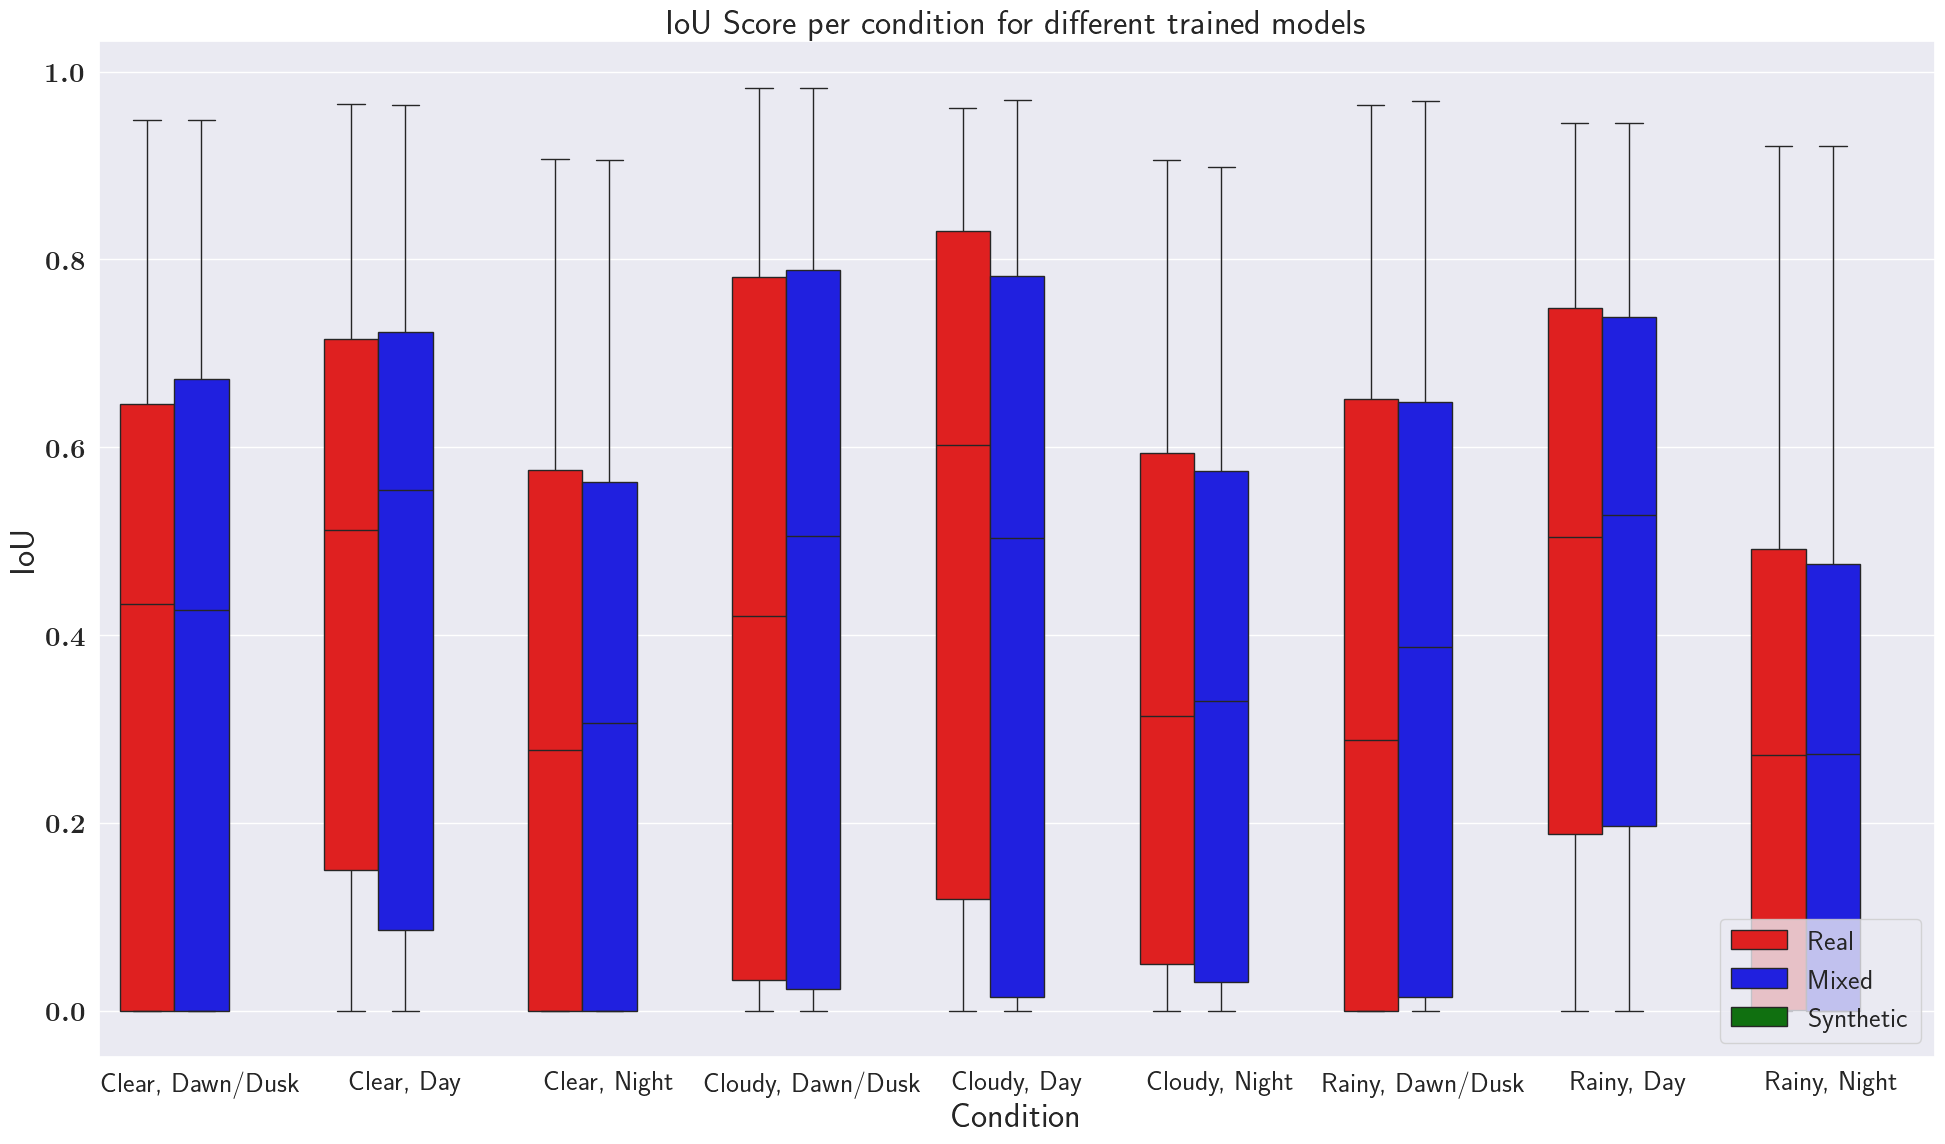

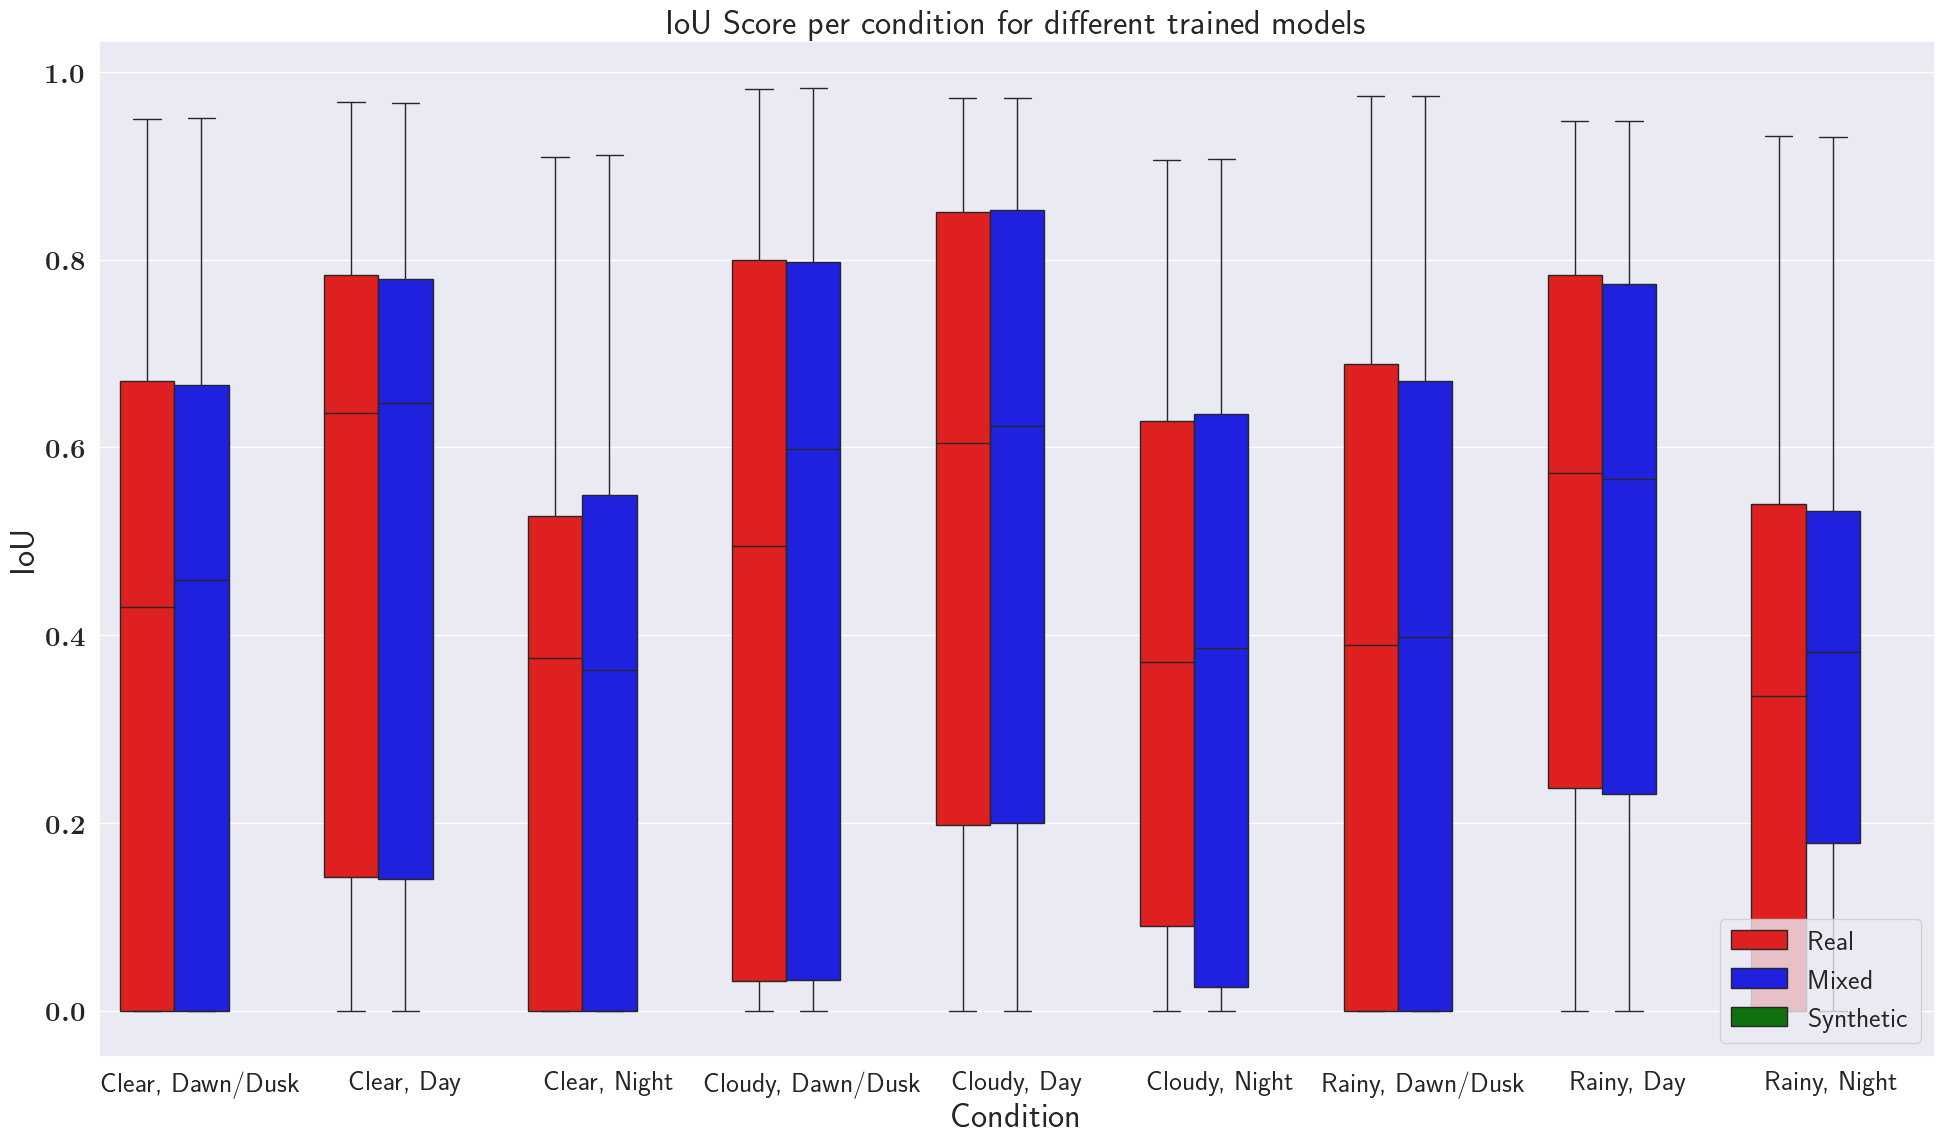

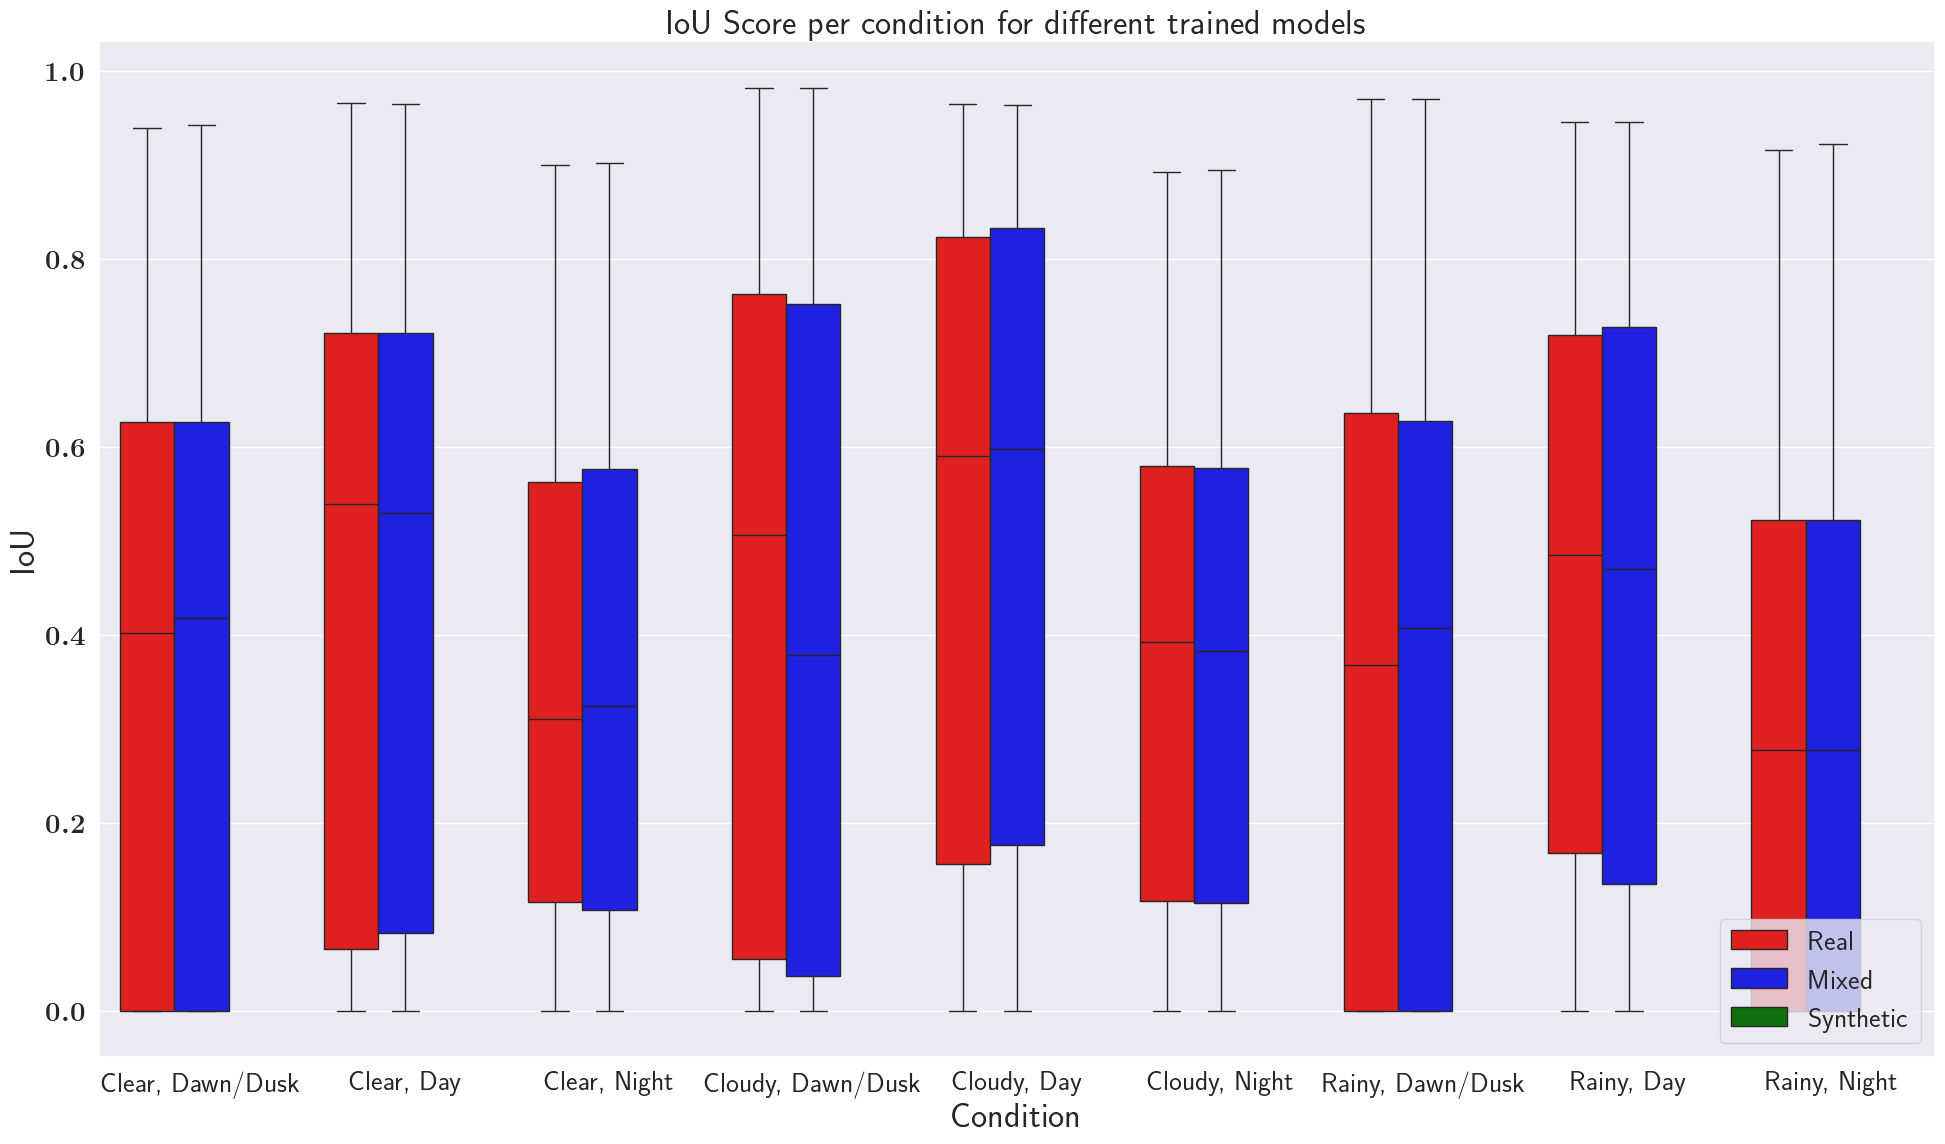

In [36]:
order = ['Real','Mixed','Synthetic']
for k,v in model_idxs.items():
    print('Plots for model: ', k)
    all_data_iou = pd.DataFrame(columns=['model', 'condition', 'IoU'])
    all_data_iou['model'] = all_data['model']
    all_data_iou['condition'] = all_data['condition']
    all_data_iou['IoU'] = all_data['IoU']
    all_data_iou['dataset'] = all_data['dataset']
    all_data_iou = all_data_iou.iloc[v]

    all_models = list(all_data_iou['model'].unique())
    
    hue_order = []
    j=0
    # sort by order
    # for i in order:
    #     for model in all_models:
    #         if i in model:
    #             hue_order.append(model)
    #             all_models.remove(model)
    hue_order = order
    print(all_data_iou)
    all_data_iou = all_data_iou.explode('IoU').reset_index()

    set_plot_properties(
        font_size= 25,
        legend_font_size = 20,
        xtick_label_size = 20,
        ytick_label_size = 20,
        markersize = 15,
        usetex = True,
    )
    # Creating a box plot for accuracy of each ltl_group, differentiated by model
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.boxplot(all_data_iou,
                        x='condition',
                        y='IoU', 
                        hue='dataset', 
                        palette=pallete[:len(all_data_iou['condition'].unique())],
                        hue_order=hue_order,
                        ax=ax)
    plt.legend(fontsize=20, loc='lower right')
    plt.title('IoU Score per condition for different trained models', fontsize=25)
    plt.ylabel('IoU', fontsize=25)
    plt.xlabel('Condition', fontsize=25)



ValueError: Could not interpret value `Dice` for `y`. An entry with this name does not appear in `data`.

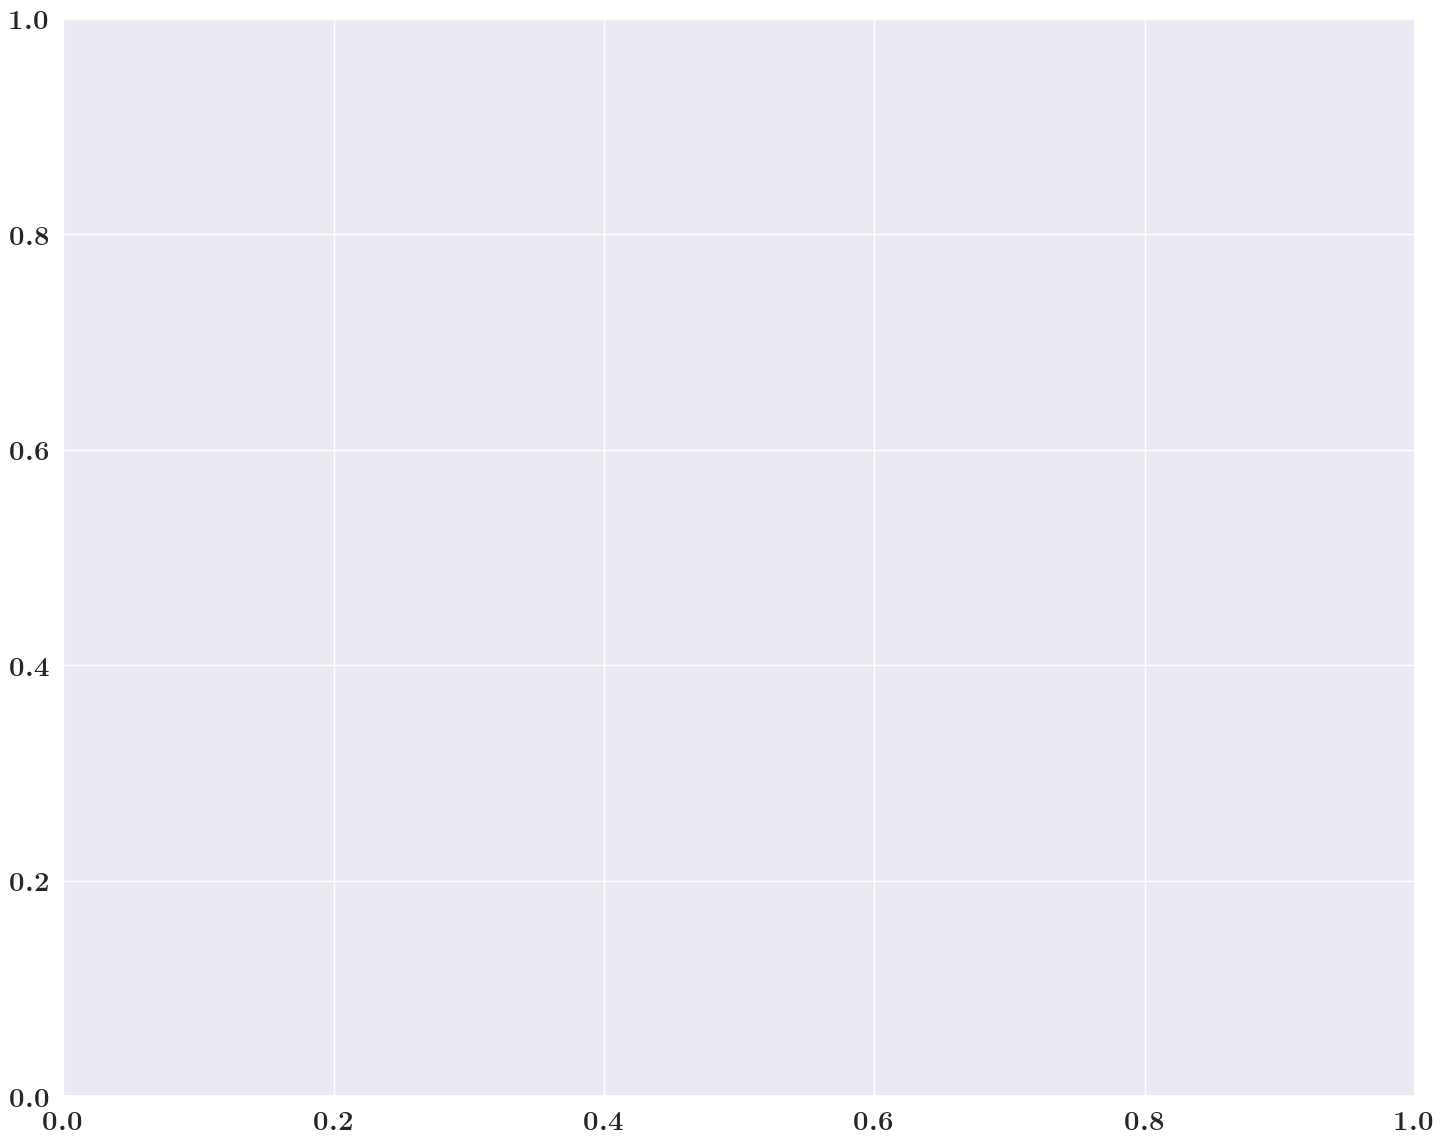

In [37]:
all_data_dice = pd.DataFrame(columns=['model', 'condition', 'Dice'])
all_data_dice['model'] = all_data['model']
all_data_dice['condition'] = all_data['condition']
all_data_dice['Dice'] = all_data['Dice']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='Dice', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)


In [ ]:
all_data_f1 = pd.DataFrame(columns=['model', 'condition', 'F1'])
all_data_f1['model'] = all_data['model']
all_data_f1['condition'] = all_data['condition']
all_data_f1['F1'] = all_data['F1']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='F1', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)


# Correcting the set of conditions


In [ ]:
DF_COND = MODEL_DATA[list(MODEL_DATA.keys())[0]]
columns = ['content_name', 'context_frame', 'camera_id','condition']
data = DF_COND[columns]

# Save the data to a compiled CSV file


In [ ]:
print(total_area_intersect.items)
print(len(total_area_intersect))